## Suppl. Fig. 3 panel E XGBoost classifier

This notebook is used to train an XGBoost classifier to predict organelle compartment using enrichment table  
The training data is confined to the ground truth in organelle_ground_truth_v6.0

Note: This notebook uses a different env than the rest of the notebooks


In [2]:
import os
import pickle
import numpy as np # require numpy version <= 1.23
import pandas as pd
import sys
import seaborn as sns
import umap
import anndata as ad
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import plotly.io as pio
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path


plt.rcParams['pdf.fonttype'] = 42
script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))
from utils.label_processing import attach_annotations
from external import clustering_workflows
from pyseus.plotting import plotly_umap as pu


### load data

In [3]:
# timestamp = datetime.now().strftime('%Y-%m-%d')
# print(f"Timestamp: {timestamp}")    

In [4]:
#manually set the timestamp to use the intermediate results from another date
timestamp = "2023-10-21-imp5"

In [5]:
# define files to load
input_dir = Path.cwd().parent.parent.parent / "Fig2" / "panel_C" / "output"
umap_table_path = input_dir / f"{timestamp}_umap_table.csv"
quants_path = input_dir / f"{timestamp}_quants.csv"

# load data
try:
    # load the file
    umap_table = pd.read_csv(umap_table_path, index_col=0)
except FileNotFoundError:
    print(f"File {umap_table_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {umap_table_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

try:
    # load the file
    quants = pd.read_csv(quants_path, index_col=0)
except FileNotFoundError:
    print(f"File {quants_path} not found.\nPlease run Fig2_C_consensus_annotation.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {quants_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [6]:
# add nuclear, cytoplasm labels from Itzhak et al. to augment the ground truths

# attach labels
labels_csv = data_path / "external" / "Itzhak_nuclear_cytoplasm.csv"

lookup_table = pd.read_csv(labels_csv)
to_df = umap_table.copy()
list_of_cols_to_add = reversed(["Global classifier2"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c , from_on="Gene name canonical", to_on="Gene_name_canonical")
    umap_table.insert(3, "Itzhak_nuclear_cytoplasm", new_col_data)

In [7]:
umap_table.columns

Index(['Protein IDs', 'Majority protein IDs', 'Gene names',
       'Itzhak_nuclear_cytoplasm', 'naming_status', 'Itzhak_compartment',
       'Itzhak_global', 'Graph-based_localization_annotation',
       'consensus_graph_annnotation', 'v0_clusters', 'Gene_name_canonical',
       'v1p2_clusters', 'v1_clusters_seed_8842', 'v1_clusters_seed_2078',
       'leiden_res_13_seed_148', 'Oct16_clusters', 'organelle_ML4.0',
       'core_complex_id', 'Oct25_clusters', 'Nov16_clusters',
       'organelle_ground_truth_v6.0', 'cluster_annotation', '13-GOLGA2',
       '12-G3BP1', '13-RAB7A', '12-YWHAQ', '13-RAB14', '12-TOMM20',
       '13-RAB11A', '13-RAB1A', '12-RTN4', '12-ACTB', '12-LAMP1', '12-SEC61B',
       '05-EDC4', '03-HSPA1B', '05-NCLN', '03-SEC23A', '01-CAPRIN1',
       '03-HSP90AA', '05-CAV1', '07-CLTA', '06-CCDC47', '02-GOLGA2', '07-COG8',
       '02-DCP1A', '02-COPE', '06-YWHAB', '02-ATG101', '14-RAB14',
       '17-CAPRIN1', '15-G3BP1', '14-RAB11A', '14-COPE', '17-MAP1LC3B',
       '15-TO

### Prepare data for XGBoost

In [8]:
# scale the data
scaled = pu.scale_table(matrix=quants, method='standard')

exp_X = scaled
exp_y = umap_table["consensus_graph_annnotation"].astype("category")

# convert the expert labels to integers
unique_strings = list(set(exp_y)) # Get unique strings
str_to_int_mapping = {string: index for index, string in enumerate(unique_strings)} # Create a mapping from strings to unique integers
exp_y = [str_to_int_mapping[s] for s in exp_y] # Convert the list of strings to a list of integers

In [9]:
# define the GT column and check for nan
GT_col = "organelle_ground_truth_v6.0"
print(f"The total number of labels in {GT_col} is {umap_table[GT_col].notna().sum()}")


The total number of labels in organelle_ground_truth_v6.0 is 1355


In [10]:
# remove nuclear_pore
print(f"the length of ground truth data is {len(umap_table[~(umap_table[GT_col].isna())])}")
umap_table[GT_col].replace('nuclear_pore', np.nan, inplace=True)
print(f"the length of ground truth data (after removing nuclear_pore) is {len(umap_table[~(umap_table[GT_col].isna())])}")

the length of ground truth data is 1355
the length of ground truth data (after removing nuclear_pore) is 1335


In [11]:
# subsample ribosome

# get all ribosome indices
ribosome_idx = umap_table.index[umap_table[GT_col] == "ribosome"]
ribosome_to_keep_in_GT = np.random.choice(ribosome_idx, 30, replace = False)
ribosome_to_remove_from_GT = [x for x in ribosome_idx if x not in ribosome_to_keep_in_GT]

# remove the ribosome samples that is not chosen in the subsampling
print(f'the length of GT class "ribosome" (before subsampling ribosome) is {len(umap_table[(umap_table[GT_col]=="ribosome")])}')
umap_table.loc[ribosome_to_remove_from_GT, GT_col] = np.nan
print(f'the length of GT class "ribosome" (after subsampling ribosome) is {len(umap_table[(umap_table[GT_col]=="ribosome")])}')

# mark in expert labels the removed ribosomes
print(f'length of expert label class "translation" (before subsampling ribosome)  is {len(umap_table[(umap_table["consensus_graph_annnotation"]=="translation")])}')
umap_table.loc[ribosome_to_remove_from_GT, "consensus_graph_annnotation"] = "translation"
print(f'length of expert label class "translation" (after subsampling ribosome)  is {len(umap_table[(umap_table["consensus_graph_annnotation"]=="translation")])}')

the length of GT class "ribosome" (before subsampling ribosome) is 77
the length of GT class "ribosome" (after subsampling ribosome) is 30
length of expert label class "translation" (before subsampling ribosome)  is 144
length of expert label class "translation" (after subsampling ribosome)  is 160


In [12]:
# add the itzhak nuclear cytoplasm labels (only add where the ML6.0 GT is not available)

# get all indices where Itzhak is Mostly Nuclear and ML6.0 is NaN
Itzhak_Nuc_ML6_Nan = umap_table.index[(umap_table['Itzhak_nuclear_cytoplasm'] == "Mostly Nuclear") & (umap_table[GT_col].isna())]
print(f"count of PGs where Itzhak is Nuclear and ML GT is NaN: {len(Itzhak_Nuc_ML6_Nan)}")

# get all indices where Itzhak is Mostly Cytosol and ML6.0 is NaN
Itzhak_Cyto_ML6_Nan = umap_table.index[(umap_table['Itzhak_nuclear_cytoplasm'] == "Mostly Cytosolic") & (umap_table[GT_col].isna())]
print(f"count of PGs where Itzhak is Cytosolic and ML GT is NaN: {len(Itzhak_Cyto_ML6_Nan)}")

# randonly pick about 300 samples from each of the above two lists
Itzhak_Nuc_ML6_Nan_tofill = np.random.choice(Itzhak_Nuc_ML6_Nan, 400 , replace=False)
Itzhak_Cyto_ML6_Nan_tofill = np.random.choice(Itzhak_Cyto_ML6_Nan, 400 , replace=False)
print(f"randomly picked {len(Itzhak_Nuc_ML6_Nan_tofill)} samples from the first list")
print(f"randomly picked {len(Itzhak_Cyto_ML6_Nan_tofill)} samples from the second list")


count of PGs where Itzhak is Nuclear and ML GT is NaN: 975
count of PGs where Itzhak is Cytosolic and ML GT is NaN: 1744
randomly picked 400 samples from the first list
randomly picked 400 samples from the second list


In [13]:
# add the itzhak nuclear cytoplasm labels (only add where the ML6.0 GT is not available)

# mask to fill
Nuc_tofill = umap_table.index.isin(Itzhak_Nuc_ML6_Nan_tofill)
Cyto_tofill = umap_table.index.isin(Itzhak_Cyto_ML6_Nan_tofill)
# fill the NaNs in the GT column
umap_table.loc[Nuc_tofill, GT_col] = umap_table.loc[Nuc_tofill, GT_col].fillna(umap_table.loc[Nuc_tofill,'Itzhak_nuclear_cytoplasm'])

umap_table.loc[Cyto_tofill, GT_col] = umap_table.loc[Cyto_tofill, GT_col].fillna(umap_table.loc[Cyto_tofill, 'Itzhak_nuclear_cytoplasm'])

umap_table[GT_col].replace('Mostly Cytosolic', 'Cytosol', inplace=True)
umap_table[GT_col].replace('Mostly Nuclear', 'Nuclear', inplace=True)
print(f"the length of ground truth data (after add Itzhak nuc/cyto) is {len(umap_table[~(umap_table[GT_col].isna())])}")

the length of ground truth data (after add Itzhak nuc/cyto) is 2088


In [14]:
idx_keep = ~(umap_table[GT_col].isna())
gt_X = scaled[idx_keep]
gt_y = umap_table[GT_col][idx_keep].astype("category")

# convert the expert labels to integers
unique_labels = sorted(list(set(gt_y))) # Get unique strings
str_to_int_mapping = {string: index for index, string in enumerate(unique_labels)} # Create a mapping from strings to unique integers
int_to_str_mapping = {index: string for index, string in enumerate(unique_labels)} # Create a mapping from strings to unique integers
gt_y = [str_to_int_mapping[s] for s in gt_y] # Convert the list of strings to a list of integers


print(f"the length of ground truth data is {len(gt_y)}")

the length of ground truth data is 2088


compute class weights

In [15]:
unique_classes = np.unique(gt_y)
total_instances = len(gt_y)
num_classes = len(unique_classes)

class_weights = {}

for cls in unique_classes:
    lab = int_to_str_mapping[cls]
    print(f"class {cls} ({lab}) has {np.sum(np.array(gt_y) == cls)} instances")
    #print(f"{total_instances} / {(num_classes * np.sum(np.array(gt_y) == cls))}")
    class_weights[cls] = total_instances / (num_classes * np.sum(np.array(gt_y) == cls))



class 0 (Cytosol) has 400 instances
class 1 (ER) has 337 instances
class 2 (ERGIC) has 40 instances
class 3 (Golgi) has 40 instances
class 4 (Nuclear) has 400 instances
class 5 (actin-binding_protein) has 37 instances
class 6 (centrosome) has 64 instances
class 7 (early_endosome) has 15 instances
class 8 (lysosome) has 47 instances
class 9 (mitochondria) has 339 instances
class 10 (p-body) has 15 instances
class 11 (peroxisome) has 24 instances
class 12 (plasma membrane) has 204 instances
class 13 (ribosome) has 30 instances
class 14 (stress granule) has 96 instances


### XGBoost hyperparameters sweep

In [16]:
sweep = True
scoring_metric = "f1_weighted"

Grid scan scoring: F1_weighted

In [17]:
if sweep:
    n_splits = 3
    n_proc = 10
    print(f"Parallel Parameter optimization using {n_proc} processes")

    pipeline = Pipeline([
        ('resampling', SMOTEENN(smote=SMOTE(k_neighbors=3))),
        ('classifier', xgb.XGBClassifier(n_jobs=1, tree_method="hist", enable_categorical=True, objective = "multi:softprob",))
    ])

    # xgb_model = xgb.XGBClassifier(
    #         n_jobs= 1, tree_method="hist", enable_categorical=True,
    #         #early_stopping_rounds = 50
    #     )

    grid = GridSearchCV(
            estimator = pipeline, n_jobs=n_proc, verbose = 1,
            param_grid = {"classifier__max_depth": [2,3,4,5,6,7], 
                        "classifier__n_estimators": [100, 200,],
                        "classifier__booster": ["gbtree"], #"gblinear", "dart"
                        'classifier__learning_rate': [0.1,  0.2, 0.25, 0.3,  0.35, 0.4],
                        'classifier__gamma': [0,0.00005, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01],
                        'classifier__grow_policy': ['depthwise', 'lossguide']},                      
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(gt_X, gt_y),
            scoring = scoring_metric)

    grid.fit(gt_X, gt_y)

    print("model best score: ", grid.best_score_)
    print("model best params: ", grid.best_params_)

Parallel Parameter optimization using 10 processes
Fitting 3 folds for each of 1584 candidates, totalling 4752 fits


KeyboardInterrupt: 

Baye search scoring: F1_weighted

In [18]:
n_splits = 3
n_proc = 10
print(f"Parallel Parameter optimization using {n_proc} processes")

pipeline = Pipeline([
    ('resampling', SMOTEENN(smote=SMOTE(k_neighbors=3))),
    ('classifier', xgb.XGBClassifier(n_jobs=1, tree_method="hist", enable_categorical=True, objective = "multi:softprob",))
])

param_grid = {"classifier__max_depth": [2,3,4,5,6,7], 
                "classifier__n_estimators": [100, 200, 300, 400, 500, 600],
                "classifier__booster": ["gbtree"], #"gblinear", "dart"
                'classifier__learning_rate': [0.1, 0.125, 0.15,0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4],
                'classifier__gamma': [0,0.00005, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.2, 0.4, 0.7],
                'classifier__grow_policy': ['depthwise', 'lossguide']}

Bayes= BayesSearchCV(
        estimator = pipeline, n_jobs=n_proc, verbose = 1,
        search_spaces=param_grid,
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(gt_X, gt_y),
        scoring="f1_weighted")

Bayes.fit(gt_X, gt_y)

print("model best score: ", Bayes.best_score_)
print("model best params: ", Bayes.best_params_)

Parallel Parameter optimization using 10 processes
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitti

c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
model best score:  0.8831467558220369
model best params:  OrderedDict([('classifier__booster', 'gbtree'), ('classifier__gamma', 0.001), ('classifier__grow_policy', 'depthwise'), ('classifier__learning_rate', 0.2), ('classifier__max_depth', 3), ('classifier__n_estimators', 300)])


### XGBoost model training

In [20]:
use_saved_model = False

In [21]:
# balance class labels with SMOTEENN
smote = SMOTEENN(smote=SMOTE(k_neighbors=3))
gt_X_bal, gt_y_bal = smote.fit_resample(gt_X, gt_y)

In [22]:
unique_classes = np.unique(gt_y_bal)
total_instances = len(gt_y_bal)
num_classes = len(unique_classes)
print(f"the number of classes is {num_classes}")

the number of classes is 15


In [23]:
# winning XGBoost parameters when cv fold = 3
params_fold3 = {"n_jobs": 2, "tree_method": "hist", "enable_categorical": True,  "verbosity": 0, # fixed parameters
    'booster': 'gbtree', 'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 2000, # sweeped parameters
    "eval_metric":['mlogloss', 'merror','auc'], "early_stopping_rounds": 50, "objective" : "multi:softprob",
} # best parameters from grid search (c.v. fold = 3, eval_metric = 'f1_weighted')

# winning XGBoost parameters when cv fold = 4
params_fold4 = {"n_jobs": 2, "tree_method": "hist", "enable_categorical": True,  "verbosity": 0, # fixed parameters
    'booster': 'gbtree', 'gamma': 0, 'grow_policy': 'lossguide', 'learning_rate': 0.35, 'max_depth': 4, 'n_estimators': 2000, # sweeped parameters
    "eval_metric":['mlogloss', 'merror','auc'], "early_stopping_rounds": 50, "objective" : "multi:softprob",
} # best parameters from grid search (c.v. fold = 4, eval_metric = 'f1_weighted')

#### Train with cross validation

In [32]:
n_splits = 3
params = params_fold3
verbose = False # whether to print the training progress

models = []
unseen = [] # save the unseen data for each fold (for roc auc calculation)


if not use_saved_model:
    sfk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in sfk.split(gt_X_bal, gt_y_bal):

        X_train, X_unseen = gt_X_bal[train_index], gt_X_bal[test_index]
        y_train, y_unseen = np.array(gt_y_bal)[train_index], np.array(gt_y_bal)[test_index]

        xgb_model = xgb.XGBClassifier(**params)
        model = xgb_model.fit(X_train, y_train, eval_set=[(X_unseen, y_unseen)], verbose = False)

        models.append(model)
        unseen.append((X_unseen, y_unseen))
else:
    sfk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in sfk.split(gt_X_bal, gt_y_bal):

        X_train, X_unseen = gt_X_bal[train_index], gt_X_bal[test_index]
        y_train, y_unseen = np.array(gt_y_bal)[train_index], np.array(gt_y_bal)[test_index]

        model_file_name = f"xgb_model_{timestamp}"
        f"output/{model_file_name}.json"
        model = xgb.XGBClassifier()
        model.load_model(f"output/{model_file_name}.json")

        models.append(model)


In [33]:
#Predict
i_fold = 0
X_unseen, y_unseen = unseen[i_fold]
y_score = models[i_fold].predict_proba(X_unseen)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_unseen == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

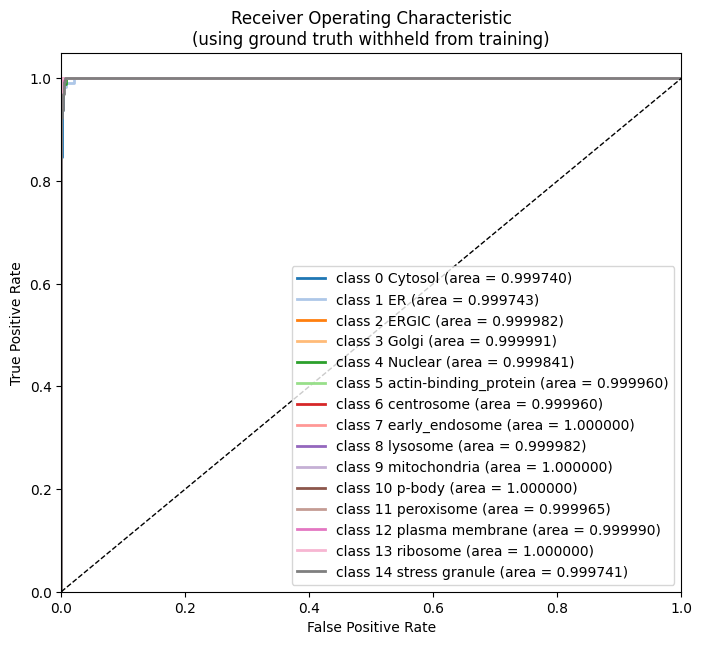

In [39]:
plt.figure(figsize=(8,7))
# Plot the ROC curve for each class
colors = plt.cm.tab20(range(20))[0:num_classes]

#colors = ["#E6194B","#3CB44B","#FFE119","#4363D8","#F58231","#911EB4","#46F0F0","#F032E6","#BCF60C","#FABEBE","#E6BEFF",]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='class {0} {1} (area = {2:0.6f})'
             ''.format(i, int_to_str_mapping[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic\n(using ground truth withheld from training)')
plt.legend(loc="lower right")
plt.show()

### Plot prob on UMAP

make predictions

In [30]:
# make predictios, get the probability for each class
X = scaled

model = models[0]

pred = model.predict_proba(X)
pred.shape
#pred[0,:]

(8541, 15)

In [31]:
int_to_str_mapping

{0: 'Cytosol',
 1: 'ER',
 2: 'ERGIC',
 3: 'Golgi',
 4: 'Nuclear',
 5: 'actin-binding_protein',
 6: 'centrosome',
 7: 'early_endosome',
 8: 'lysosome',
 9: 'mitochondria',
 10: 'p-body',
 11: 'peroxisome',
 12: 'plasma membrane',
 13: 'ribosome',
 14: 'stress granule'}

In [32]:
pred[:,1]

array([4.6417504e-04, 1.3838782e-03, 7.4297466e-05, ..., 9.4823634e-05,
       4.6950975e-03, 1.6794518e-04], dtype=float32)

run Leiden clustering

In [33]:
# define resolutions to run
res_list = [0.631, 1.58, 3.98, 5.51, 9.0, 13, 17]
# define a fixed seed for reproducibility
fixed_seed = 9044

# generating AnnData
selected = enrichments['sample'][selected_samples].copy()
adata = ad.AnnData(selected)

adata.var_names = selected.columns.to_list()
adata.obs_names = enrichments['metadata']["Protein IDs"].to_list()
adata.obs["Protein IDs"] = enrichments['metadata']["Protein IDs"].to_list()
adata.obs["Majority protein IDs"] = enrichments['metadata']["Majority protein IDs"].to_list()
adata.obs["Gene names"] = enrichments['metadata']["Gene_name_canonical"].to_list()

clusters = []
# this cell is for running clusters at variable resolutions
for i in res_list:
    print(i)
    adata = adata.copy()
    # clearing any memory for cluster class object in the for loop
    cluster=None

    # start clusteringworkflow class / preprocessing
    cluster = clustering_workflows.ClusteringWorkflow(adata=adata)
    cluster.preprocess(n_pcs=None)

    # umap neighbor calculation and ARI calculation
    cluster.calculate_neighbors(n_pcs=None, n_neighbors=20)
    
    # leiden clustering
    cluster.run_leiden(resolution=i, random_state=fixed_seed)
    name = 'leiden_res_' + str(i)
    one = pd.DataFrame(cluster.adata.obs['leiden'].rename(name))
    clusters.append(one)

clusters.insert(0, enrichments['metadata'])

# for some reason pd.concat(clusters, axis=1) doesnt work and I can't figure out why.
# Adding the columns manually
base = clusters[0]
leiden_res_names = []
# for i in np.arange(1,11):
for i, res in enumerate(res_list):
    name = 'leiden_res_' + str(res)
    leiden_res_names.append(name)
    base[name] = clusters[i+1][name].to_list()
    umap_table[name] = clusters[i+1][name].to_list()

c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning:

Transforming to str index.



0.631
1.58
3.98
5.51
9.0
13
17


run umap

In [34]:
# scale the table for UMAP
scaled = pu.scale_table(matrix=quants, method='standard')

# set the UMAP seed (for 3D UMAP, the seed for 2D UMAP will be sweeped)
seed = 1234
# set other UMAP parameters, these shouldn't be changed
n_neighbors = 20
min_dist = 0.1
metric = 'euclidean'

fit = umap.UMAP(
    n_neighbors=n_neighbors, 
    min_dist=min_dist, 
    metric=metric, 
    random_state=seed
)
u = fit.fit_transform(scaled)



c:\Users\duo.peng\Anaconda3\envs\xgb2\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [35]:
# add UMAP coordinates to the table
umap_table["umap_1"] = u[:,0]
umap_table["umap_2"] = u[:,1]


In [36]:

# add class probabilities to the table
for k, v in int_to_str_mapping.items():
    umap_table[f"prob_{v}"] = pred[:,k]

# add clase predictions to the table
class_pred = pred.argmax(axis=1)
organelle_pred = [int_to_str_mapping[x] for x in class_pred]
umap_table["organelle_pred"] = organelle_pred

In [37]:
#flip the UMAP 

# Find the maximum x and y values
max_x = max(u[:,0])
max_y = max(u[:,1])

# Flip both x and y coordinates
umap_1_flip = max_x - u[:,0]
umap_2_flip = max_y - u[:,1]

umap_table["umap_1_flip"] = umap_1_flip
umap_table["umap_2_flip"] = umap_2_flip

Plot ground truth 

In [38]:
# generate 2D UMAP plot (hightlighted by Leiden clusters)
label_to_color = "organelle_ML6.0" # **choose which annotation column to highlight here**

fig = pu.interaction_umap(umap_table,
    node_name='Gene_name_canonical', cluster=label_to_color,
    unlabelled_color='#D0D3D4', unlabelled_opacity=0.1,
    x='umap_1_flip', y='umap_2_flip',
    categorical=True)
fig.update_layout(width=1200, height=800)
fig.update_layout(title_text=f"Ground truth: {label_to_color}")

#save the figure as an html file
save_path = os.path.join("output")
save_name = f"htmls/UMAP_color_{label_to_color}_{timestamp}_input_{file_name_chosen}.html"
pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

plot expert labels

In [39]:
# generate 2D UMAP plot (hightlighted by Leiden clusters)
label_to_color = "consensus_graph_annnotation" # **choose which annotation column to highlight here**

fig = pu.interaction_umap(umap_table,
    node_name='Gene_name_canonical', cluster=label_to_color,
    unlabelled_color='#D0D3D4', unlabelled_opacity=0.1,
    x='umap_1_flip', y='umap_2_flip',
    categorical=True)
fig.update_layout(width=1200, height=800)
fig.update_layout(title_text=f"Expert labels: {label_to_color}")

#save the figure as an html file
save_path = os.path.join("output")
save_name = f"htmls/UMAP_color_{label_to_color}_{timestamp}_input_{file_name_chosen}.html"
pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

plot class prediction

In [40]:
# generate 2D UMAP plot (hightlighted by Leiden clusters)
label_to_color = "organelle_pred" # **choose which annotation column to highlight here**

fig = pu.interaction_umap(umap_table,
    node_name='Gene_name_canonical', cluster=label_to_color,
    unlabelled_color='#D0D3D4', unlabelled_opacity=0.1,
    x='umap_1_flip', y='umap_2_flip',
    categorical=True)
fig.update_layout(width=1200, height=800)
fig.update_layout(title_text=f"Classifier: {label_to_color}")

#save the figure as an html file
save_path = os.path.join("output")
save_name = f"htmls/UMAP_color_{label_to_color}_{timestamp}_input_{file_name_chosen}.html"
pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

In [41]:
output = "output"
if not os.path.exists(output):
    os.makedirs(output)
    

plot probability

In [42]:
for col in umap_table.columns:
    if col.startswith("prob"):
        # generate 2D UMAP plot (hightlighted by Leiden clusters)
        label_to_color = col # **choose which annotation column to highlight here**

        fig = pu.interaction_umap(umap_table,
            node_name='Gene_name_canonical', cluster=label_to_color,
            unlabelled_color='#D0D3D4', unlabelled_opacity=0.1,
            x='umap_1_flip', y='umap_2_flip',
            categorical=False)
        fig.update_layout(width=1200, height=800)
        fig.update_layout(title_text=f"Probability: {label_to_color.replace('prob_','')}")

        plt.show()

        #save the figure as an html file
        save_path = os.path.join("output")
        save_name = f"htmls/UMAP_color_{label_to_color}_{timestamp}_input_{file_name_chosen}.html"
        pio.write_html(fig, file=os.path.join(save_path, save_name), auto_open=False)

In [43]:
umap_table["consensus_graph_annnotation"].unique()

array(['nucleus', 'Golgi', 'cytosol', 'trans-Golgi', 'early_endosome',
       'stress_granule', 'mixed', 'centrosome', 'ER',
       'recycling_endosome', 'plasma_membrane', 'mitochondrion',
       'lysosome', 'actin_cytoskeleton', 'translation', 'nucleolus',
       '14-3-3_scaffold', 'peroxisome', 'p-body', 'ERGIC', 'proteasome',
       'spindle'], dtype=object)

In [44]:
umap_table["organelle_pred"].unique()

array(['Nuclear', 'stress granule', 'Golgi', 'Cytosol', 'ERGIC', 'p-body',
       'centrosome', 'plasma membrane', 'ER', 'actin-binding_protein',
       'early_endosome', 'mitochondria', 'ribosome', 'lysosome',
       'peroxisome'], dtype=object)

### Using same color mapping to plot the class-prediction and expert labels

In [45]:
# fill na
umap_table["consensus_graph_annnotation"].fillna("unlabeled", inplace=True)

In [46]:
# get the list of unique labels
lab_mapping = {"Nuclear": "nucleus",
           "Cytosol": "cytosol",
           "ribosome": "translation",
           'stress granule': "stress_granule",
           "plasma membrane": "plasma_membrane",
           "mitochondria": "mitochondrion",
           "actin-binding_protein": "actin_cytoskeleton"} # pred to expert mapping

unique_exp_clusters = umap_table["consensus_graph_annnotation"].unique()
unique_pred_labels = umap_table["organelle_pred"].unique()

all_labels = pd.concat([umap_table["consensus_graph_annnotation"],umap_table["organelle_pred"]]).unique()
all_labels = [lab_mapping[i] if i in lab_mapping.keys() else i for i in all_labels]
all_labels = list(set(all_labels))

print(f"total number of labels is {len(all_labels)}")

total number of labels is 22


In [47]:
# generate a copy of the mapping with new labels

int_to_str_mapping2 = {k:lab_mapping[v] if v in lab_mapping.keys() else v for k, v in int_to_str_mapping.items()}
str_to_int_mapping2 = {v:k for k, v in int_to_str_mapping2.items()}

#save to pickle
savedir = os.path.join("feature_subset_analysis", "input")
if not os.path.exists(savedir):
    os.makedirs(savedir)
pickle.dump(int_to_str_mapping2, open(os.path.join(savedir,f"{timestamp}_int_to_str_mapping2.pkl"), "wb"))
pickle.dump(str_to_int_mapping2, open(os.path.join(savedir,f"{timestamp}_str_to_int_mapping2.pkl"), "wb"))


In [48]:
int_to_str_mapping2

{0: 'cytosol',
 1: 'ER',
 2: 'ERGIC',
 3: 'Golgi',
 4: 'nucleus',
 5: 'actin_cytoskeleton',
 6: 'centrosome',
 7: 'early_endosome',
 8: 'lysosome',
 9: 'mitochondrion',
 10: 'p-body',
 11: 'peroxisome',
 12: 'plasma_membrane',
 13: 'translation',
 14: 'stress_granule'}

In [49]:
str_to_int_mapping2

{'cytosol': 0,
 'ER': 1,
 'ERGIC': 2,
 'Golgi': 3,
 'nucleus': 4,
 'actin_cytoskeleton': 5,
 'centrosome': 6,
 'early_endosome': 7,
 'lysosome': 8,
 'mitochondrion': 9,
 'p-body': 10,
 'peroxisome': 11,
 'plasma_membrane': 12,
 'translation': 13,
 'stress_granule': 14}

In [50]:
# define the color palette for the of unique labels
total_color = len(sorted(all_labels))
if total_color <= 20:
    palette = sns.color_palette("tab20", n_colors=total_color)
else:
    palette = sns.color_palette("tab20", n_colors=20) + sns.color_palette("tab20b", n_colors=20)[-(total_color-20):]

# generate color mapping for the expert labels
color_mapping_Oct25 = dict(zip(unique_exp_clusters, palette))
# use the same color mapping for the predicted labels
color_mapping_pred = {p : color_mapping_Oct25[lab_mapping[p]] if p in lab_mapping.keys() else color_mapping_Oct25[p] for p in unique_pred_labels}

# convert colors to hex
def rgb_to_css_color(rgb_tuple):
    """Convert RGB tuple in [0, 1] range to CSS color (hexadecimal format)."""
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb_tuple[0] * 255),
        int(rgb_tuple[1] * 255),
        int(rgb_tuple[2] * 255)
    )
color_mapping_Oct25 = {k: rgb_to_css_color(v) for k, v in color_mapping_Oct25.items()}
color_mapping_pred = {k: rgb_to_css_color(v) for k,v in color_mapping_pred.items()}

In [51]:
# plot side-by-side
fig1 = px.scatter(
            umap_table,
            x="umap_1_flip",
            y="umap_2_flip",
            hover_name='Gene_name_canonical',
            color="consensus_graph_annnotation",
            #color_continuous_scale=px.colors.cyclical.mygbm[: -1], # small palette (Kibeom)
            #color_discrete_sequence=px.colors.qualitative.Dark24, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            color_discrete_map = color_mapping_Oct25, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            hover_data=None,
            template='simple_white')
fig1.update_traces(marker=dict(size=6))
fig1.update(layout_coloraxis_showscale=False)
fig1.update_layout(width=1200, height=800)
fig1.update_layout(title_text=f"Oct25 clusters", title_x=0.5, title_y=0.95, title_font_size=20)
fig1.update_legends(title_text='Oct25 clusters', title_font_size=16, font_size=16 )

save_path = os.path.join("output")
save_name = f"htmls/Consistent_color_UMAP_consensus_graph_annnotation_{timestamp}_input_{file_name_chosen}.html"
pio.write_html(fig1, file=os.path.join(save_path, save_name), auto_open=False)


In [52]:

fig2 = px.scatter(
            umap_table,
            x="umap_1_flip",
            y="umap_2_flip",
            hover_name='Gene_name_canonical',
            color="organelle_pred",
            #color_continuous_scale=px.colors.cyclical.mygbm[: -1], # small palette (Kibeom)
            #color_discrete_sequence=px.colors.qualitative.Dark24, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            color_discrete_map = color_mapping_pred, # Duo: expand the color palette # for more options, see https://plotly.com/python/discrete-color/
            hover_data=None,
            template='simple_white')
fig2.update_traces(marker=dict(size=6))
fig2.update(layout_coloraxis_showscale=False)
fig2.update_layout(width=1200, height=800)
fig2.update_layout(title_text=f"Classifier prediction", title_x=0.5, title_y=0.95, title_font_size=20)
fig2.update_legends(title_text='Predicted organelle', title_font_size=16, font_size=16)

save_path = os.path.join("output")
save_name = f"htmls/Consistent_color_UMAP_organelle_pred_{timestamp}_input_{file_name_chosen}.html"
pio.write_html(fig2, file=os.path.join(save_path, save_name), auto_open=False)

### Compute ROC and PR curves using expert data

In [53]:
umap_table["organelle_pred"].unique()

array(['Nuclear', 'stress granule', 'Golgi', 'Cytosol', 'ERGIC', 'p-body',
       'centrosome', 'plasma membrane', 'ER', 'actin-binding_protein',
       'early_endosome', 'mitochondria', 'ribosome', 'lysosome',
       'peroxisome'], dtype=object)

In [54]:
umap_table["consensus_graph_annnotation"].unique()

array(['nucleus', 'Golgi', 'cytosol', 'trans-Golgi', 'early_endosome',
       'stress_granule', 'mixed', 'centrosome', 'ER',
       'recycling_endosome', 'plasma_membrane', 'mitochondrion',
       'lysosome', 'actin_cytoskeleton', 'translation', 'nucleolus',
       '14-3-3_scaffold', 'peroxisome', 'p-body', 'ERGIC', 'proteasome',
       'spindle'], dtype=object)

converted pred labels to expert labels (for ROC curve calculation)

In [55]:
# converted pred labels to expert labels
umap_table["organelle_pred"].replace(lab_mapping, inplace=True)

In [56]:
umap_table["organelle_pred"].unique()

array(['nucleus', 'stress_granule', 'Golgi', 'cytosol', 'ERGIC', 'p-body',
       'centrosome', 'plasma_membrane', 'ER', 'actin_cytoskeleton',
       'early_endosome', 'mitochondrion', 'translation', 'lysosome',
       'peroxisome'], dtype=object)

check if each pred label is in expert label

In [57]:
# check if each pred label is in expert label
for i in umap_table["organelle_pred"].unique():
    if i not in umap_table["consensus_graph_annnotation"].unique():
        print(i)

Remove GT data

In [58]:
print(f"Prior to removal of PG with GT: umap_table shape: {umap_table.shape}")

Prior to removal of PG with GT: umap_table shape: (8541, 106)


In [59]:
# Remove GT data
no_GT_mask = umap_table["organelle_ML6.0"].isna()
umap_table_no_GT = umap_table[no_GT_mask].copy()
umap_table_no_GT.shape

(6453, 106)

Remove PGs whose classes in expert but not in GT

In [60]:
# Remove classes in expert but not in GT
mask = umap_table_no_GT["consensus_graph_annnotation"].isin(umap_table_no_GT["organelle_pred"].unique())
umap_table_no_GT_class_match = umap_table_no_GT[mask].copy()
umap_table_no_GT_class_match.shape

(5115, 106)

In [61]:
# compute ROC

#subset the predictions to what's left in the umap table
y_score = pred[umap_table_no_GT_class_match.index] 

y_expert =  umap_table_no_GT_class_match["consensus_graph_annnotation"].astype("category")
y_expert = np.array([str_to_int_mapping2[s] for s in y_expert]) # Convert the list of strings to a list of integers


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_expert == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [62]:
int_to_str_mapping2

{0: 'cytosol',
 1: 'ER',
 2: 'ERGIC',
 3: 'Golgi',
 4: 'nucleus',
 5: 'actin_cytoskeleton',
 6: 'centrosome',
 7: 'early_endosome',
 8: 'lysosome',
 9: 'mitochondrion',
 10: 'p-body',
 11: 'peroxisome',
 12: 'plasma_membrane',
 13: 'translation',
 14: 'stress_granule'}

In [63]:
umap_table["organelle_ML6.0"]

0         NaN
1         NaN
2       Golgi
3         NaN
4       Golgi
        ...  
8536      NaN
8537      NaN
8538      NaN
8539      NaN
8540      NaN
Name: organelle_ML6.0, Length: 8541, dtype: object

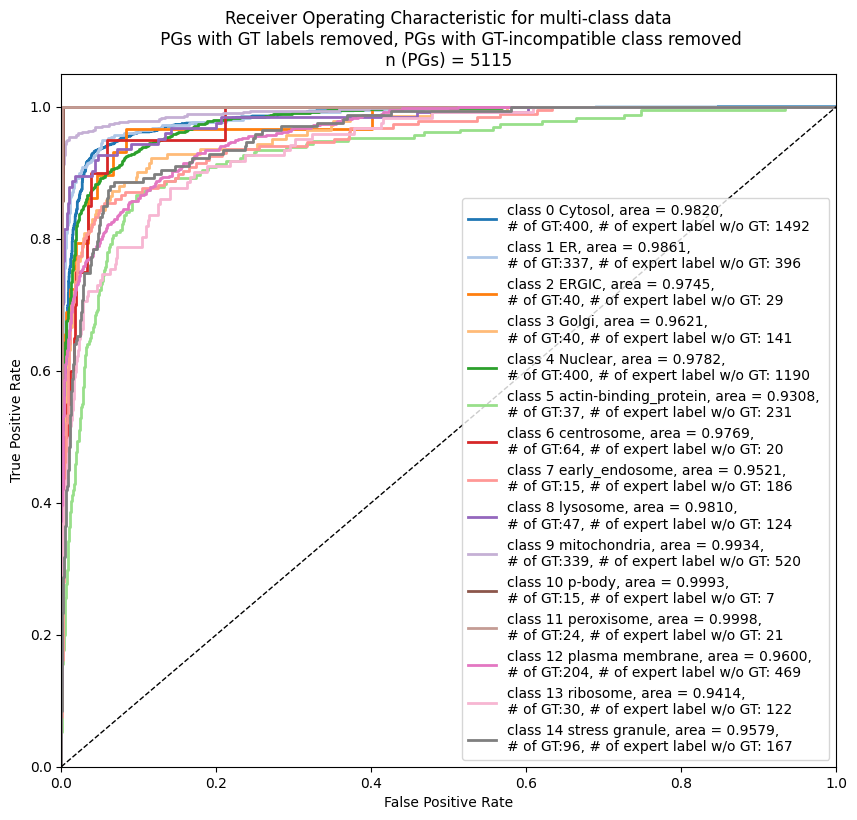

In [64]:
plt.figure(figsize=(10,9))
# Plot the ROC curve for each class
colors = plt.cm.tab20(range(20))[0:num_classes]

#colors = ["#E6194B","#3CB44B","#FFE119","#4363D8","#F58231","#911EB4","#46F0F0","#F032E6","#BCF60C","#FABEBE","#E6BEFF",]
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='class {0} {1}, area = {2:0.4f}, \n# of GT:{3}, # of expert label w/o GT: {4}'
             ''.format(i, int_to_str_mapping[i], roc_auc[i],
                       (umap_table["organelle_ML6.0"] == int_to_str_mapping[i]).sum(),
                       (umap_table_no_GT_class_match["consensus_graph_annnotation"] == int_to_str_mapping2[i]).sum())
            )


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for multi-class data\n PGs with GT labels removed, PGs with GT-incompatible class removed\n n (PGs) = {umap_table_no_GT_class_match.shape[0]} ')
plt.legend(loc="lower right")
plt.savefig(os.path.join("output", f"ROC_{timestamp}.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### write table to file

In [65]:
umap_table.to_csv(f"output/umap_table_with_xgb_pred_{timestamp}.csv")

In [66]:
cols = [i for i in umap_table.columns if i.startswith("prob") or i.endswith("pred")]
umap_table_subset = umap_table[cols].copy()
umap_table_subset["Protein IDs"] = umap_table["Protein IDs"].copy()

In [67]:
# add predictions to Manu's csv
df = pd.read_csv("input/leiden_res_17_seed_9044_UMAP_embeddings_seed1234_(scores_org=10.53_comp=5.69)_input=Oct21_ref_imp5_enrichment_table_NOC_prop.csv")
df = pd.merge(df, umap_table_subset, on="Protein IDs", how="left")
df.to_csv(f"output/leiden_res_17_seed_9044_UMAP_embeddings_seed1234_(scores_org=10.53_comp=5.69)_xgbPred_{timestamp}.csv")

### Save the model to file

In [68]:
model_file_name = f"xgb_model_{timestamp}"
model.save_model(f"output/{model_file_name}.json")

## Calculate prediction uncertainty

In [69]:
def calculate_entropy(probabilities):
    """
    Calculate the entropy of a probability distribution.
    
    :param probabilities: array-like, probabilities for each class
    :return: entropy, a measure of uncertainty of the prediction
    """
    # Replace 0s with 1s to handle log(0) case, as log(1) = 0
    probabilities = np.clip(probabilities, 1e-10, 1)
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def calculate_predictive_margin(probabilities):
    """
    Calculate the predictive margin of a probability distribution.
    
    :param probabilities: array-like, probabilities for each class
    :return: margin, difference between the highest and second highest probability
    """
    sorted_probs = np.sort(probabilities)  # Sort the probabilities
    margin = sorted_probs[-1] - sorted_probs[-2]  # Subtract the second highest from the highest
    return margin

In [70]:
entropies = []
margins = []
for idx, row in df.iterrows():
    prob_cols = [i for i in row.index if i.startswith("prob")]
    prob_list = np.array(list(row[prob_cols]))
    entropy = calculate_entropy(prob_list)
    margin = calculate_predictive_margin(prob_list)
    entropies.append(entropy)
    margins.append(margin)

# add entropy and margins to the dataframe
df["predictive_entropy"] = entropies
df["predictive_margin"] = margins

# save the dataframe
df.to_csv(f"output/{timestamp}_classifier_results_input=leiden_res_17_seed_9044_UMAP_embeddings_seed1234_(scores_org=10.53_comp=5.69).csv")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


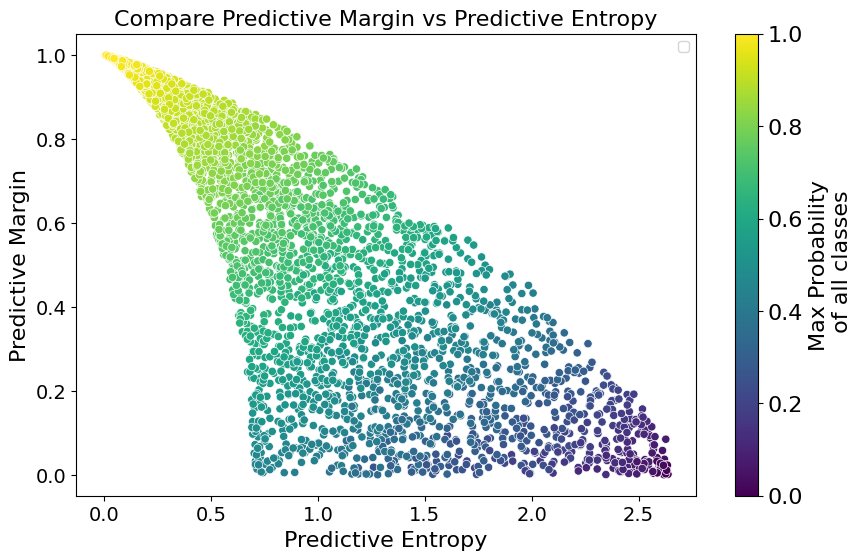

In [71]:
# plot the entropy against margin distributions
pred_columns = [col for col in df.columns if col.startswith('prob')]
df["max_prob"] = df[pred_columns].max(axis = 1)
# Plot using seaborn
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='predictive_entropy', y='predictive_margin', 
                               hue='max_prob', palette='viridis',legend=False)
plt.title('Compare Predictive Margin vs Predictive Entropy', fontsize= 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
#plt.legend(fontsize=14, title='Max Probability\n of all classes', title_fontsize=14, loc='upper right')
plt.xlabel('Predictive Entropy', fontsize=16)
plt.ylabel('Predictive Margin', fontsize=16)
colorbar = plt.colorbar(scatter_plot.collections[0])
colorbar.ax.tick_params(labelsize=16)  # Replace 10 with the desired font size
colorbar.set_label('Max Probability\n of all classes', size=16)
plt.show()

### Plot entropy distro

C:\Users\duo.peng\AppData\Local\Temp\ipykernel_86048\44164097.py:1: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<Axes: xlabel='predictive_entropy', ylabel='Count'>

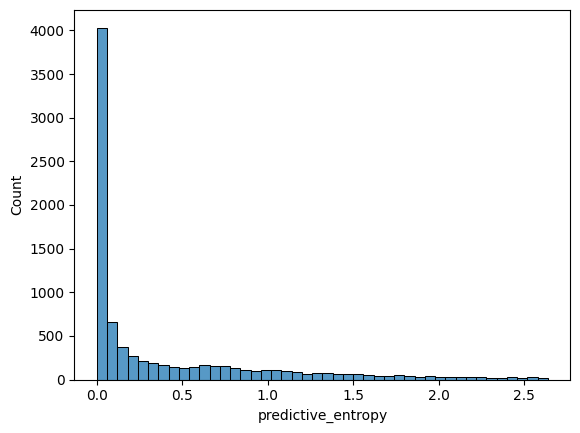

In [72]:
sns.histplot(data=df, x='predictive_entropy', palette='viridis', legend=False)

### Plot entropy of diagonal but not hit

In [73]:
# read diagonal but not hit
file_path = "../../data/pys40/labels/Nov13_sankey_data_leiden_res_1.5_diagonal_but_not_hit.csv"
diagonal_but_not_hit = pd.read_csv(file_path)

diagonal_but_not_hit = pd.merge(diagonal_but_not_hit, df, on="Protein IDs", how="left")
diagonal_but_not_hit

,Protein IDs,Majority protein IDs_x,Gene names_x,naming_status_x,Itzhak_compartment_x,Itzhak_global_x,Oct25_clusters_x,Oct16_clusters_x,v0_clusters_x,Gene_name_canonical_x,...,prob_mitochondria,prob_p-body,prob_peroxisome,prob_plasma membrane,prob_ribosome,prob_stress granule,organelle_pred,predictive_entropy,predictive_margin,max_prob
0,A0A024QYR6;A0A1V0DNR7;A0A6G6A825;F6KD02;F6KD01...,A0A024QYR6;A0A1V0DNR7;A0A6G6A825;F6KD02;F6KD01...,PTEN,checked,NaN,Mostly Cytosolic,cytosol,cytosol,NaN,PTEN,...,0.000609,0.000476,0.000535,0.000143,0.000710,0.000431,cytosol,0.077880,0.986718,0.990080
1,A0A024QYV3;Q9H7X7;B7Z2E8;A8K889;A0A024QYT8,A0A024QYV3;Q9H7X7;B7Z2E8;A8K889,RABL5;IFT22,checked,NaN,Mostly Cytosolic,mixed,cytosol,NaN,IFT22,...,0.002211,0.002662,0.002251,0.000313,0.001509,0.001295,cytosol,0.177199,0.971997,0.975406
2,Q9H875;A0A024QYV5;B4DQF4,Q9H875;A0A024QYV5,PRKRIP1,checked,Large Protein Complex,Broad distribution,mixed,mixed,nucleus,PRKRIP1,...,0.002817,0.857766,0.003834,0.000894,0.032345,0.020833,p-body,0.693369,0.809879,0.857766
3,A0A024QYX0;Q15125;C9J719;C9JJ78,A0A024QYX0;Q15125;C9J719;C9JJ78,EBP,checked,ER,Mostly Organellar,ER,ER,ER,EBP,...,0.000021,0.000022,0.000034,0.001446,0.000011,0.000004,ER,0.018422,0.996328,0.997775
4,Q9Y484;A0A024QYX1;A0A024QYW6;C9JYH8;A0A0U1RQR1...,Q9Y484;A0A024QYX1;A0A024QYW6;C9JYH8;A0A0U1RQR1...,WDR45,checked,NaN,Mostly Cytosolic,early_endosome,cytosol,trans-Golgi,WDR45,...,0.000056,0.000084,0.000071,0.000011,0.000026,0.000044,cytosol,0.008426,0.999072,0.999205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,Q9Y6X8,Q9Y6X8,ZHX2,checked,NaN,Mostly Nuclear,nucleus,nucleus,nucleus,ZHX2,...,0.000045,0.000024,0.000034,0.000097,0.000014,0.000128,nucleus,0.005611,0.999358,0.999485
1641,S4R3H4,S4R3H4,ACIN1,checked,Large Protein Complex,Mostly Nuclear,nucleus,nucleus,nucleus,ACIN1,...,0.000892,0.000784,0.000718,0.000137,0.000313,0.037451,nucleus,0.216335,0.918300,0.955752
1642,U3KQP1,U3KQP1,ASNSD1,unchecked,NaN,NaN,mixed,translation,translation,U3KQP1[p],...,0.027017,0.013142,0.013113,0.005949,0.565729,0.231024,translation,1.453146,0.334705,0.565729
1643,U3KQT9,U3KQT9,YLPM1,checked,Large Protein Complex,Mostly Nuclear,nucleus,nucleus,nucleus,YLPM1,...,0.000097,0.000042,0.000055,0.000047,0.000023,0.000037,nucleus,0.008415,0.999032,0.999203


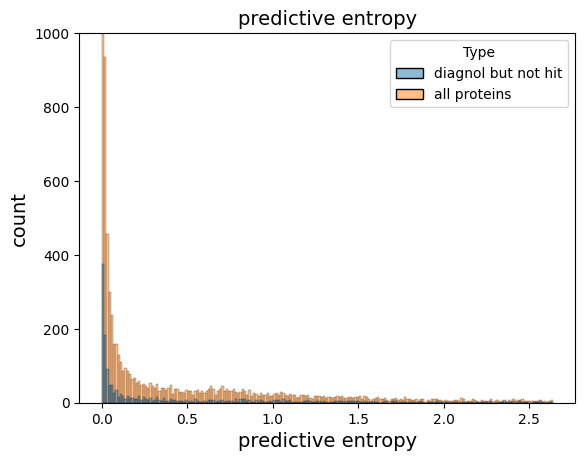

In [74]:
list1 = diagonal_but_not_hit["predictive_entropy"]
list2 = df["predictive_entropy"]
# Create a DataFrame
dftmp = pd.DataFrame({
    'diagnol but not hit': pd.Series(list1),
    'all proteins': pd.Series(list2)
})

# Melt the DataFrame for long-form data
df_long = pd.melt(dftmp, value_vars=['diagnol but not hit', 'all proteins'], var_name='Type', value_name='Value')

# Create a histogram
sns.histplot(data=df_long, x='Value', hue='Type',stat="count", common_norm=False, bins=200) # "count", "frequency", "density", "probability", "proportion", "percent",

# Add labels and title
plt.xlabel('predictive entropy', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.title('predictive entropy', fontsize = 14)
plt.ylim(0, 1000)

# Show the plot
plt.show()

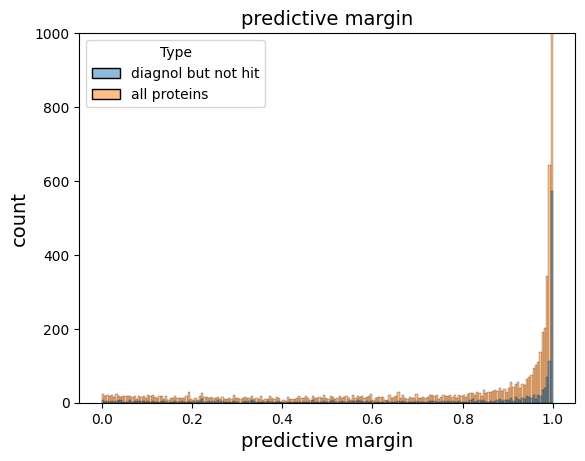

In [75]:
list1 = diagonal_but_not_hit["predictive_margin"]
list2 = df["predictive_margin"]
# Create a DataFrame
dftmp = pd.DataFrame({
    'diagnol but not hit': pd.Series(list1),
    'all proteins': pd.Series(list2)
})

# Melt the DataFrame for long-form data
df_long = pd.melt(dftmp, value_vars=['diagnol but not hit', 'all proteins'], var_name='Type', value_name='Value')

# Create a histogram
sns.histplot(data=df_long, x='Value', hue='Type',stat="count", common_norm=False, bins=200) # "count", "frequency", "density", "probability", "proportion", "percent",

# Add labels and title
plt.xlabel('predictive margin', fontsize = 14)
plt.ylabel('count', fontsize = 14)
plt.title('predictive margin', fontsize = 14)
plt.ylim(0, 1000)

# Show the plot
plt.show()